# Classification

It's a classification task where it is necessary to detect if there is fraud o not in credit cards

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("/content/drive/data/creditcard.csv")

In [3]:
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


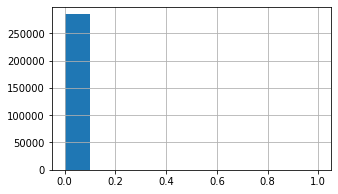

In [4]:
data.Class.hist(figsize=(5, 3))

In [6]:
print("# Class 1: {}".format(len(data[data["Class"]==1])))
print("# Class 0: {}".format(len(data[data["Class"]==0])))

# Class 1: 492
# Class 0: 284315


certainly the data in unbalanced

## Scaling Time and Amount

In [12]:
scaler = StandardScaler()
data["Time"] = scaler.fit_transform(data["Time"].values.reshape(-1, 1))
data["Amount"] = scaler.fit_transform(data["Amount"].values.reshape(-1, 1))

## Undersampling

As it could be seen previously, the data is unbalanced, so undersampling is performed to deal with this problem.

In [8]:
data = data.sample(frac=1)
data_class_1 = data[data["Class"]==1]

In [9]:
len(data_class_1)

492

In [13]:
data_class_0 = data[data["Class"]==0][0:492]
data_under = pd.concat([data_class_1, data_class_0], axis=0)
data_under.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
128479,-0.338798,-4.312479,1.886476,-2.338634,-0.475243,-1.185444,-2.112079,-2.122793,0.272565,0.290273,-3.833741,2.509781,-3.611231,-1.024300,-5.291925,1.649807,-3.262658,-4.333118,-1.863049,-0.009534,-0.718706,0.550541,-0.067870,-1.114692,0.269069,-0.020572,-0.963489,-0.918888,0.001454,-0.113344,1
16863,-1.401865,-2.787248,-0.071340,-1.505288,3.361777,-3.357422,0.565835,0.303653,0.966914,-2.245882,-3.651427,0.987277,-3.834782,-0.961354,-3.182168,-1.126002,-2.954301,-5.841218,-2.910430,-1.155850,1.607397,0.882940,-0.246202,1.752227,0.219925,0.156282,-0.265894,0.220694,0.256077,2.568812,1
43160,-1.124848,-14.970346,8.401421,-16.867238,8.252334,-13.565130,-2.782438,-14.263735,9.643419,-7.701499,-14.226698,5.610999,-11.793979,1.598387,-11.606970,-0.044180,-9.286955,-19.899726,-7.518051,1.243517,-1.614660,2.714045,-0.101355,-0.439666,0.519514,0.789328,0.064357,-1.621386,-1.104819,0.738288,1


In [14]:
len(data_under)

984

Now the data is balanced

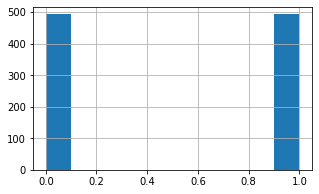

In [15]:
data_under["Class"].hist(figsize=(5, 3))

Here there are the distributions of some variables before(left side) and after(right side) applying undersampling. It can be seen that the distributions don't change drastically.

(-35.0, 10.0)

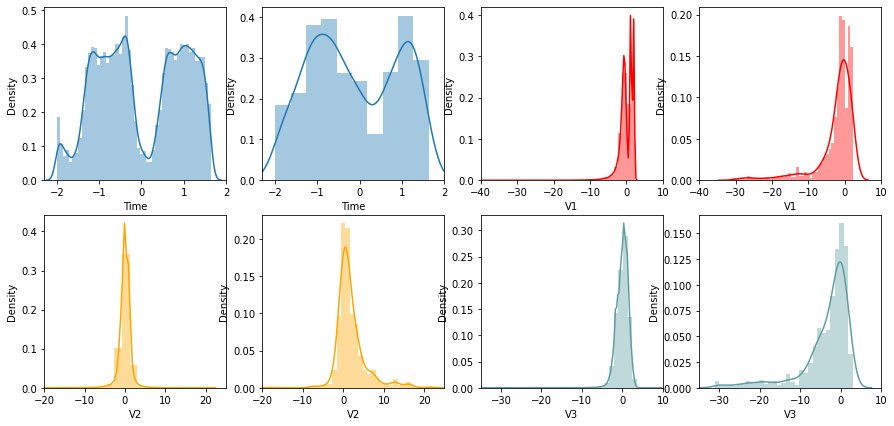

In [34]:
fig, axs = plt.subplots(2,4,figsize=(15,7))
sns.distplot(data["Time"], ax=axs[0, 0], label="data")
axs[0, 0].set_xlim(-2.3, 2)
sns.distplot(data_under["Time"], ax=axs[0, 1], label="under_data")
axs[0, 1].set_xlim(-2.3, 2)
sns.distplot(data["V1"], ax=axs[0, 2], color="red")
axs[0, 2].set_xlim(-40, 10)
sns.distplot(data_under["V1"], ax=axs[0, 3], color="red")
axs[0, 3].set_xlim(-40, 10)
sns.distplot(data["V2"], ax=axs[1, 0], color="orange")
axs[1, 0].set_xlim(-20, 25)
sns.distplot(data_under["V2"], ax=axs[1, 1], color="orange")
axs[1, 1].set_xlim(-20, 25)
sns.distplot(data["V3"], ax=axs[1, 2], color="cadetblue")
axs[1, 2].set_xlim(-35, 10)
sns.distplot(data_under["V3"], ax=axs[1, 3], color="cadetblue")
axs[1, 3].set_xlim(-35, 10)

## Dimensionality reduction

PCA is performed to check if the conditions(fraud/non fraud) can be easily seen.

In [35]:
pca = PCA(n_components=2)
pca_under = pca.fit_transform(data_under)
pca_data_under = pd.DataFrame(data = pca_under[:,:], columns=["pc1","pc2"])
pca_data_under["Class"] = data_under.loc[:, "Class"].values
pca_data_under["Class"] = pca_data_under["Class"].replace(1, "Fraud")
pca_data_under["Class"] = pca_data_under["Class"].replace(0, "Non fraud")

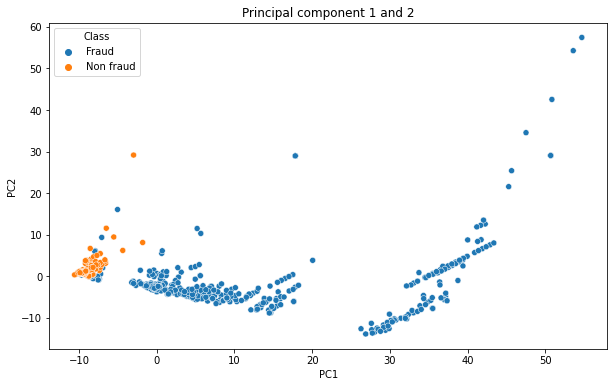

In [79]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=pca_data_under, x="pc1", y="pc2", hue="Class")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('Principal component 1 and 2')
plt.show()

## Split train and test sets with UnderSampled data



The data is splitted using stratify=y with the main of splitting both of the classes of a balanced way.

In [39]:
y = data_under[["Class"]]
x = data_under.drop(["Class"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

In [40]:
print("Classes in train set")
print("# Class 1: {0:.2f}%".format((len(y_train[y_train["Class"]==1])/len(y_train))*100))
print("# Class 0: {0:.2f}%".format((len(y_train[y_train["Class"]==0])/len(y_train))*100))

Classes in train set
# Class 1: 50.06%
# Class 0: 49.94%


In [41]:
print("Classes in test set")
print("# Class 1: {0:.2f}%".format((len(y_test[y_test["Class"]==1])/len(y_test))*100))
print("# Class 0: {0:.2f}%".format((len(y_test[y_test["Class"]==0])/len(y_test))*100))

Classes in test set
# Class 1: 49.75%
# Class 0: 50.25%


## Feature selection of UnderSampledData

To select the most important variables it was performed SelectKBest and RandomForestClassifier algorithms

### SelectKBest

#### f_classif

In [42]:
selector = SelectKBest(f_classif, k=4)
selector.fit(x_train, y_train)

names = np.array(list(x_train.columns))
names = names.T
names = names.tolist()

importance = selector.scores_.T
importance = importance.tolist()

features = pd.DataFrame({"names":names, "importance":importance})
features = features.sort_values("importance",ascending=False)

Text(0.5, 1.0, 'SelectKBest with f_classif')

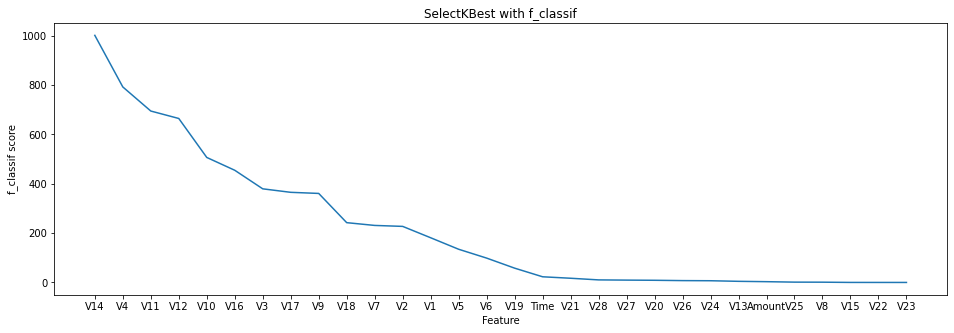

In [43]:
plt.rcParams["figure.figsize"] = [16,5]
plt.plot(features.importance.values)
plt.xticks(np.arange(30),list(features.names))
plt.xlabel("Feature")
plt.ylabel("f_classif score")
plt.title('SelectKBest with f_classif')

#### mutual_info_classif

In [44]:
selector = SelectKBest(mutual_info_classif, k=4)
selector.fit(x_train, y_train)

names = np.array(list(x_train.columns))
names = names.T
names = names.tolist()

importance = selector.scores_.T
importance = importance.tolist()

features = pd.DataFrame({"names":names, "importance":importance})
features = features.sort_values("importance",ascending=False)

Text(0.5, 1.0, 'SelectKBest with mutual_info_classif')

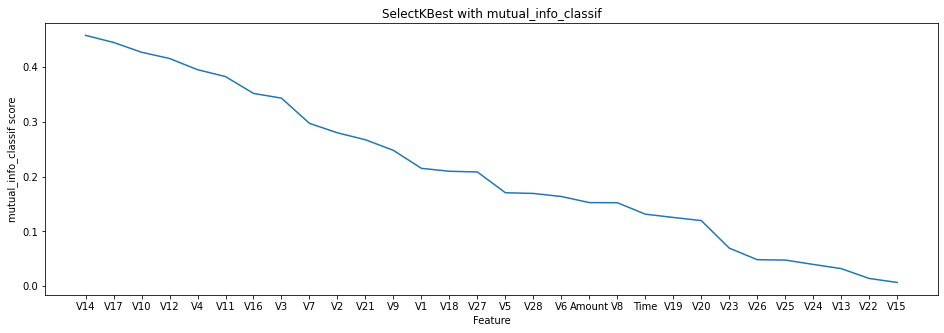

In [45]:
plt.rcParams["figure.figsize"] = [16,5]
plt.plot(features.importance.values)
plt.xticks(np.arange(30),list(features.names))
plt.xlabel("Feature")
plt.ylabel("mutual_info_classif score")
plt.title('SelectKBest with mutual_info_classif')

### RandomForest to feature Selection

In [46]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(x_train, y_train)

names = np.array(list(x_train.columns))
names = names.T
names = names.tolist()

importance = rf.feature_importances_.T
importance = importance.tolist()

features = pd.DataFrame({"names":names, "importance":importance})
features = features.sort_values("importance")

Text(0.5, 1.0, 'RandomForest to feature selection')

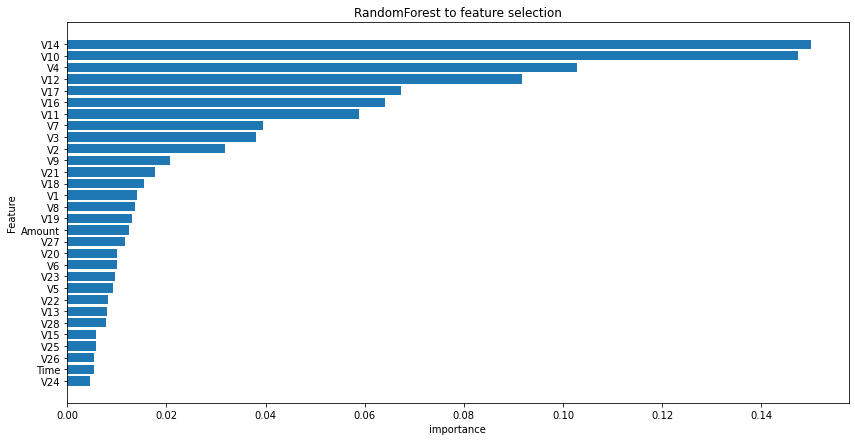

In [47]:
plt.rcParams["figure.figsize"] = [14,7]
plt.barh(features.names.values, features.importance.values)
plt.xlabel("importance")
plt.ylabel("Feature")
plt.title('RandomForest to feature selection')

Top 10 of most important features according to every algorithm used.

mutual_info_classif: V14, V10, V17, V12, V11, V4, V16, V13, V7, V9

random_forest: V14, V10, V12, V4, V17, V11, V16, V3, V7, V18 

f_classif : V14, V4, V12, V10, V16, V3, V9, V17, V2, V7

According to the previous information, the next features where chosen

In [48]:
x_train = x_train[["V14", "V17", "V4", "V10", "V12", "V11", "V3", "V16", "V7"]]

In [49]:
corr = x_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2).set_properties(**{'font-size': '8pt'})

,V14,V17,V4,V10,V12,V11,V3,V16,V7
V14,1.00,0.74,-0.80,0.76,0.89,-0.90,0.67,0.79,0.55
V17,0.74,1.00,-0.71,0.86,0.88,-0.77,0.74,0.95,0.77
V4,-0.80,-0.71,1.00,-0.79,-0.83,0.79,-0.78,-0.74,-0.72
V10,0.76,0.86,-0.79,1.00,0.88,-0.80,0.86,0.86,0.85
V12,0.89,0.88,-0.83,0.88,1.00,-0.90,0.77,0.91,0.72
V11,-0.90,-0.77,0.79,-0.80,-0.90,1.00,-0.72,-0.82,-0.64
V3,0.67,0.74,-0.78,0.86,0.77,-0.72,1.00,0.74,0.88
V16,0.79,0.95,-0.74,0.86,0.91,-0.82,0.74,1.00,0.75
V7,0.55,0.77,-0.72,0.85,0.72,-0.64,0.88,0.75,1.00


Due that there is a correlation of 95% between V16 and V17, it was decided to delete V16.

In [50]:
x_train = x_train[["V14", "V17", "V4", "V10", "V12", "V11", "V3", "V7"]]
x_test = x_test[["V14", "V17", "V4", "V10", "V12", "V11", "V3", "V7"]]

In [51]:
corr = x_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2).set_properties(**{'font-size': '8pt'})

,V14,V17,V4,V10,V12,V11,V3,V7
V14,1.00,0.74,-0.80,0.76,0.89,-0.90,0.67,0.55
V17,0.74,1.00,-0.71,0.86,0.88,-0.77,0.74,0.77
V4,-0.80,-0.71,1.00,-0.79,-0.83,0.79,-0.78,-0.72
V10,0.76,0.86,-0.79,1.00,0.88,-0.80,0.86,0.85
V12,0.89,0.88,-0.83,0.88,1.00,-0.90,0.77,0.72
V11,-0.90,-0.77,0.79,-0.80,-0.90,1.00,-0.72,-0.64
V3,0.67,0.74,-0.78,0.86,0.77,-0.72,1.00,0.88
V7,0.55,0.77,-0.72,0.85,0.72,-0.64,0.88,1.00


## Modeling

At this point 5 classifiers were used and at the end one of them is chosen according to its performance

In [52]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [53]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [54]:
names = []
train_scores = []
test_scores = []
for name, model in models:
  result = cross_validate(model, x_train, y_train, return_train_score=True, cv=10, scoring="accuracy")
  train_score = round(np.mean(result["train_score"]), 2)
  test_score = round(np.mean(result["test_score"]), 2)
  names.append(name)
  train_scores.append(train_score)
  test_scores.append(test_score)

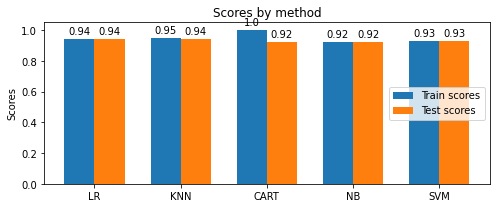

In [55]:
x = np.arange(len(names))  
width = 0.35  

fig, ax = plt.subplots(figsize=(7,3))
train_sc = ax.bar(x - width/2, train_scores, width, label='Train scores')
test_sc = ax.bar(x + width/2, test_scores, width, label='Test scores')

ax.set_ylabel('Scores')
ax.set_title('Scores by method')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc="right")

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(train_sc)
autolabel(test_sc)
fig.tight_layout()
plt.show()

In [56]:
class Curves():

  def __init__(self, sizes, models, x_train, y_train, scoring):
    self.sizes = sizes
    self.models = models
    self.x_train = x_train
    self.y_train = y_train
    self.scoring = scoring

  def train(self):
    model_name = []
    train_scs = []
    test_scs = []
    for name, model in self.models:
      train_sizes, train_scores, test_scores = learning_curve(model,
                                                              self.x_train,
                                                              self.y_train,
                                                              train_sizes=self.sizes,
                                                              scoring=self.scoring)
      model_name.append(name)
      train_scs.append(np.mean(train_scores, axis = 1))
      test_scs.append(np.mean(test_scores, axis = 1))

    df_scores = pd.DataFrame({"name":model_name, "train_score":train_scs, "test_score":test_scs})
    return(df_scores)

  def learning_c(self):
    df_scs = self.train()
    fig, ax = plt.subplots(5, 1, figsize=(7, 19))
    for i in range(len(df_scs)):
      ax[i].plot(self.sizes,
                 [x for x in list(df_scs.loc[i, "train_score"])],
                 label = "Training Score",
                 color = 'b')
      ax[i].plot(self.sizes,
                 [x for x in list(df_scs.loc[i, "test_score"])],
                 label = "Train_val_score",
                 color = 'g')
      ax[i].set_ylim(0.81, 1.01)
      ax[i].set_title((df_scs.loc[i, "name"]))
      ax[i].legend()

  def roc_c(self):
    fig, ax= plt.subplots(1, figsize=(7, 5))
    for name, model in self.models:
      model.fit(x_train, y_train)
      plot_roc_curve(model, x_test, y_test, ax=ax, name=name)
      

In [58]:
models = [('LR', LogisticRegression()), ('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()),
          ('NB', GaussianNB()), ('SVM', SVC())]
          
sizes = np.linspace(0.1, 1.0, 5)

prueba = Curves(sizes, models, x_train, y_train, scoring="recall")

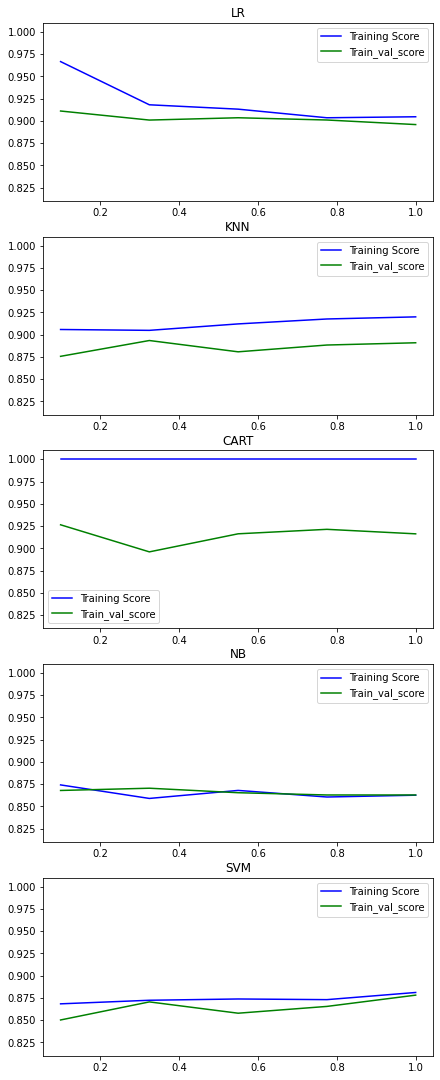

In [59]:
prueba.learning_c()

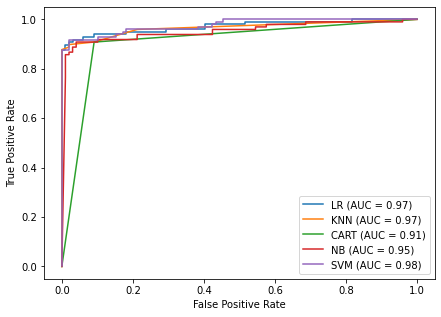

In [60]:
prueba.roc_c()

The 5 classifiers have similar performance on the learning curve and the ROC, then it was decided to work with LogisticRegression because it has good performance and it is the most basic method.

## Hyperparameter Optimization

In [61]:
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [62]:
params = {"C": np.arange(0.01, 1, 0.1)}

In [63]:
estimator = LogisticRegression()

In [64]:
ggrid = GridSearchCV(estimator, 
                     param_grid = params,
                     scoring="recall",
                     cv=5
                    )

In [65]:
final_model = ggrid.fit(x_train, y_train)

In [66]:
ggrid.cv_results_, ggrid.best_params_, ggrid.best_score_

({'mean_fit_time': array([0.01020665, 0.01047907, 0.00905228, 0.00959539, 0.00957966,
         0.00885963, 0.00887237, 0.00789857, 0.00883975, 0.00791783]),
  'mean_score_time': array([0.00275998, 0.00219731, 0.00281839, 0.00226378, 0.00252314,
         0.00221543, 0.00223627, 0.00197964, 0.00229998, 0.00204892]),
  'mean_test_score': array([0.88065563, 0.89587796, 0.89587796, 0.89587796, 0.89840961,
         0.89840961, 0.89840961, 0.89840961, 0.89840961, 0.89840961]),
  'param_C': masked_array(data=[0.01, 0.11, 0.21000000000000002, 0.31000000000000005,
                     0.41000000000000003, 0.51, 0.6100000000000001,
                     0.7100000000000001, 0.81, 0.91],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'C': 0.01},
   {'C': 0.11},
   {'C': 0.21000000000000002},
   {'C': 0.31000000000000005},
   {'C': 0.41000000000000003},
   {'C': 0.51},

In [67]:
final_results = cross_validate(ggrid.best_estimator_, 
                               x_train, y_train, 
                               return_train_score=True,
                               cv=5, scoring="recall")

In [68]:
test_scores = final_results["test_score"]
train_scores = final_results["train_score"]
print(np.mean(train_scores))
print(np.mean(test_scores))

0.903550331525015
0.8984096072703668


In [74]:
final_estimator = LogisticRegression(C=0.41)

In [75]:
final_estimator.fit(x_train, y_train)

LogisticRegression(C=0.41, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
predicte = final_estimator.predict(x_test)

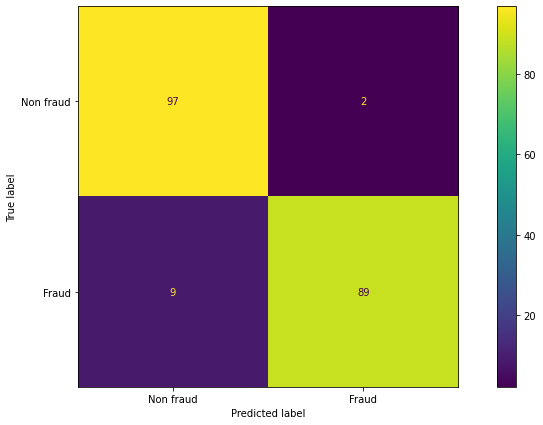

In [81]:
plot_confusion_matrix(final_estimator, x_test, y_test, display_labels=["Non fraud", "Fraud"])  
plt.show()

In [78]:
target_names = ['Non fraud', 'Fraud']
print(classification_report(y_test, predicte, target_names=target_names))

              precision    recall  f1-score   support

   Non fraud       0.92      0.98      0.95        99
       Fraud       0.98      0.91      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197



Although good results were obtained , 9% of the frauds were incorretly detected as non frauds, so it is important to improve recall.